### load in TCGA data

1. BRCA stage 1 survival plots using PCA, to KM plots

2. BRCA stage 2 survival plots using PCA, to KM plots

3. Pan-cancer log rank survival plots

4. ipython notebook for figures


In [1]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['legend.numpoints'] = 1
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import ttest_ind
import seaborn as sns
import os
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
sns.set(style='white')


/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
def loadDf(fname):
    with open(fname+'.column.txt') as f:
        myIndex=map(lambda s:s.replace("\n",""), f.readlines())
    with open(fname+'.row.txt') as f:
        myColumns=map(lambda s:s.replace("\n",""), f.readlines())
    cacheLoad(fname+".npy")
    tmpMatrix=np.load(cacheName(fname+".npy"))
    return pd.DataFrame(tmpMatrix,index=myIndex,columns=myColumns)

In [3]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import pandas.rpy.common as com
stats = importr('stats')

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  app.launch_new_instance()


## param

In [5]:
tcgaGeneDfDir='inputData/TCGAmatrix.realign.gene'
metaDataDir='inputData/patientDeathVitalDF.csv'
hgncConvertedDir=tcgaGeneDfDir+'.hgnc'
baseDataOutDir='./DATA_OUT/'
meanThreshold=5

In [6]:
metaDf=pd.DataFrame.from_csv('inputData/patientDeathVitalDF.csv')

## load in TCGA data

In [7]:
def loadDf(fname):
    with open(fname+'.column.txt') as f:
        myIndex=map(lambda s:s.replace("\n",""), f.readlines())
    with open(fname+'.row.txt') as f:
        myColumns=map(lambda s:s.replace("\n",""), f.readlines())
    tmpMatrix=np.load(fname+".npy")
    return pd.DataFrame(tmpMatrix,index=myIndex,columns=myColumns)

In [8]:
tcgaGeneDf=loadDf(hgncConvertedDir)

In [9]:
brcaFullMetaDf=pd.DataFrame.from_csv('./inputData/nationwidechildrens.org_clinical_patient_brca.txt',sep='\t').iloc[2:]
brcaFullMetaDf.index=brcaFullMetaDf.index.str.upper()
m1=(metaDf.disease.isin(['BRCA']))
subPartialMetaDf=metaDf[m1&(metaDf.sample_type=='TP')&(~metaDf.filename.str.contains('bam'))]
algnedFullMeta=brcaFullMetaDf.loc[subPartialMetaDf.participant_id]
algnedFullMeta.index=subPartialMetaDf.index
subMetaDf=pd.concat([subPartialMetaDf,algnedFullMeta],axis=1)

In [10]:
inGeneDf=tcgaGeneDf.loc[:,tcgaGeneDf.columns.isin(subMetaDf.index)].T

In [11]:
log2Df=np.log2(inGeneDf+1)

In [12]:
from lifelines import CoxPHFitter

## read in VM data

In [13]:
quantFname='mergedResult'
pExtd='.pickle'
rawDf=pd.read_pickle('inputData/'+quantFname+pExtd)


In [14]:
expDfTmp=rawDf.loc[:,rawDf.columns.get_level_values(1).isin(['6mg','2-5mg'])].copy()
expDf=expDfTmp
cls=expDf.columns.get_level_values(0).unique()
fstOrderDeDf=pd.concat({cl:(expDf[cl]['6mg']/((expDf[cl]['2-5mg']))).T for cl in cls} ).T
meanFstOrderDeDf=fstOrderDeDf.mean(axis=1,level=0)
M=meanFstOrderDeDf.as_matrix().copy()
meanExprDf=pd.concat({cl:expDfTmp[cl].mean(axis=1,level=0).T for cl in cls}).T
Mask=(meanExprDf.min(level=0,axis=1)<5.0).as_matrix().copy() 
M[Mask]=0

In [15]:
imputedMeanFoldChangeDf=pd.DataFrame(M,index=meanFstOrderDeDf.index,columns=meanFstOrderDeDf.columns )

#### identify cancer specific and non-cancer specific gene lists

In [111]:
cancerSpecificNew=imputedMeanFoldChangeDf.index[(imputedMeanFoldChangeDf>1.5)[['HT1080','MDA']].all(axis=1)&((imputedMeanFoldChangeDf<1.5)[['HFF']]).all(axis=1)]

In [112]:
intersectAllNew=imputedMeanFoldChangeDf.index[(imputedMeanFoldChangeDf>1.5)[['HT1080','MDA','HFF']].all(axis=1)]

In [113]:
print 'cancer specific genes: ',', '.join(cancerSpecificNew)

cancer specific genes:  MRC2, LTBP1, LAMC2, ZNF532, EDN1, LPCAT2, LTBP4, LAMB1, TYRO3, HPS4, HMOX1, DAAM1, FERMT1, JAG1, SMAD7, LFNG, HES1, ID2, TGFBI, TRMT13, PODXL, COL5A1, SYNE1, ZMYM5, EPHB2, ARNTL, VHL, BHLHE40, NAV1, COL4A2, ARHGAP32, NREP, IGF2BP3, SKIL, THBS1, ITGAV, AMIGO2, FRMD6, EFCAB11, TPM1, FURIN, ABL2, LHFPL2, SNX30, TAGLN, KIN, PID1, WDR66, GALNT10, RASEF, NKX3-1, TBC1D2B, RBPJ, NLGN2, TANC2, ABLIM3, PEAK1, DPY19L1, TVP23C, AGTRAP, FAM43A, SDHAP1, COL4A1, MKL1, SIPA1L1, KCTD11, MTND2P28, GTF2IP4, H2BFS, ZNF224


In [19]:
print 'genes reponding in all cell lines : ',', '.join(intersectAllNew)

genes reponding in all cell lines :  TMEM132A, JARID2, PLAUR, PHLDB1, SMG6, FSTL3, GADD45B, SRPX, SERPINE1, PFKFB4, FOXP1, FN1, PMEPA1, ZC3H4, ADAM19, SEMA7A, IGF1R, MBOAT2, MARCH4, MYO10, UHRF2, HYOU1, FBXO32, ITGA2, CHST11, JMJD1C, TRIB1, MLXIP, SPHK1, ULK1, FZD8, NDUFA13, TENM3, UBA6-AS1, LINC00504


In [20]:
hannahGeneList=cancerSpecificNew

### attach all TCGA BRCA meta data

In [21]:
histoDf=subMetaDf[['er_status_by_ihc','pr_status_by_ihc','her2_status_by_ihc']].copy()
newM=np.zeros(shape=histoDf.shape,dtype=np.int)
newM[(histoDf=='Positive').as_matrix()]=1
newM[(histoDf=='Negative').as_matrix()]=-1
newDf=pd.DataFrame(data=newM,index=histoDf.index,columns=histoDf.columns)
newDf.columns=newDf.columns.str.replace('_status_by_ihc','')

In [22]:
patientSubtypeS=pd.Series(index=newDf.index)
patientSubtypeS.loc[((newDf.er==1)|(newDf.pr==1))&(newDf.her2==-1)]='luA'
patientSubtypeS.loc[((newDf.er==1)|(newDf.pr==1))&(newDf.her2==1)]='luB'
patientSubtypeS.loc[(newDf.er==-1)&(newDf.her2==-1)]='tn'
patientSubtypeS.loc[(newDf.er==-1)&(newDf.pr==-1)&(newDf.her2==1)]='her2'
patientSubtypeS=patientSubtypeS.fillna('unknown')

In [23]:
subMetaDf.loc[:,'histoSubtype']=patientSubtypeS[:]

In [24]:
print 'subtype value counts'
subMetaDf.histoSubtype.value_counts()

subtype value counts


luA        454
unknown    382
tn         129
luB        129
her2        37
Name: histoSubtype, dtype: int64

### subset TCGA BRCA RNAseq data

In [25]:
myTargetGeneList=hannahGeneList

subTcgaDf=tcgaGeneDf.loc[myTargetGeneList,tcgaGeneDf.columns.isin(subMetaDf.index)]
log2SubTcgaDf=np.log2(subTcgaDf+1)

## check grade assocoitation for PC1

check for stage I patients

### fit the PCA space

In [26]:
pca=PCA(n_components=3)

### transform the data to PCA space

In [27]:
pca_low_grade_brca=PCA(n_components=3)


In [28]:
stage='I_II'

(70, 195)


/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


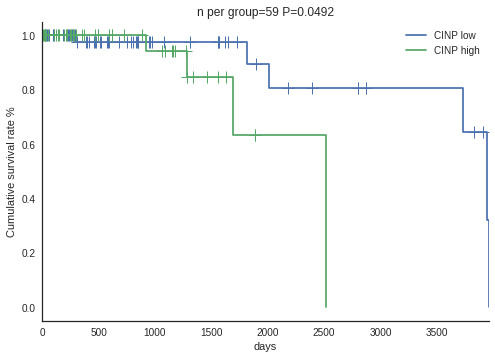

In [29]:
#!rm DATA_OUT/*
stage='I'
flip=True
topGroupLabel,bottomGroupLabel='CINP high','CINP low'

stageToPatternDict={stage:"^Stage "+stage+"[ABC]?$" for stage in ['I','II','III','IV']}
stageToPatternDict['all']='.*'

"""
***CHANGE paramter stage to see surival stat from the other stage
"""

#pca=PCA(n_components=3)

cancerType='BRCA'
quantile=0.3
myTargetGeneList=hannahGeneList

StageRegex1=stageToPatternDict[stage]
#StageRegex2=stageToPatternDict['II']
#daysThres=365.25*5
stageMask=(metaDf.grade.fillna('').str.contains(StageRegex1))\
                   #|(metaDf.grade.fillna('').str.contains(StageRegex1))
#censorMask=(~metaDf.E)&(metaDf['T']<daysThres) #take out the data censored
mySubMetaDf=metaDf[(metaDf.disease==cancerType)&stageMask
                   &(metaDf.sample_type=='TP')&(~metaDf.filename.str.contains('bam'))]
subTcgaDf=tcgaGeneDf.loc[tcgaGeneDf.index.isin(myTargetGeneList),tcgaGeneDf.columns.isin(mySubMetaDf.index)]
log2SubTcgaDf=np.log2(subTcgaDf+1)
print log2SubTcgaDf.shape
pcaM=pca.fit_transform(log2SubTcgaDf.T)
pca_low_grade_brca.fit(log2SubTcgaDf.T)
patientPcaDf=pd.DataFrame(pcaM,index=log2SubTcgaDf.columns,columns=['1','2','3'])
meanA=log2SubTcgaDf.loc[:,patientPcaDf['1']<=patientPcaDf['1'].quantile(quantile)].mean().mean()
meanB=log2SubTcgaDf.loc[:,patientPcaDf['1']>=patientPcaDf['1'].quantile(1-quantile)].mean().mean()
expressionS=(-patientPcaDf['1']) if meanB<meanA else patientPcaDf['1']
#save also the pca plot
mySubMetaDf.loc[:,'VM_score']=expressionS.loc[:]
#patientPathwayS.iloc[]
lExprPatients=expressionS.index[expressionS<=expressionS.quantile(quantile)]
hExprPatients=expressionS.index[expressionS>=expressionS.quantile(1-quantile)]
lDf,hDf=metaDf.loc[metaDf.index.isin(lExprPatients)],metaDf.loc[metaDf.index.isin(hExprPatients)]
result=logrank_test(hDf['T'],lDf['T'],hDf['E'],lDf['E']) #use log rank instead

kmf = KaplanMeierFitter()
ax = plt.subplot(111)
kmf.fit(lDf['T'], event_observed=lDf['E'], label=bottomGroupLabel)
kmf.plot(ax=ax,show_censors=True,ci_show=False)
kmf.fit(hDf['T'], event_observed=hDf['E'], label=topGroupLabel)
kmf.plot(ax=ax,show_censors=True,ci_show=False)
ax.set_title('n per group='+str(lDf.shape[0]) + " P="+str(result.p_value)[:6])
ax.set_xlabel('days')
ax.set_ylabel('Cumulative survival rate %')
sns.despine()

ax.figure.savefig(baseDataOutDir+'/BRCA_stage_'+stage+'_KM'+'.eps', bbox_inches='tight', pad_inches=0)

In [30]:
os.getcwd()+'/'+baseDataOutDir+'/BRCA_stage_'+stage+'_KM'+'.eps'

'/cellar/users/btsui/Project/STEPHANIE_FINAL/./DATA_OUT//BRCA_stage_I_KM.eps'

In [31]:
subMetaDf.loc[:,'VM_score']=expressionS.loc[:]

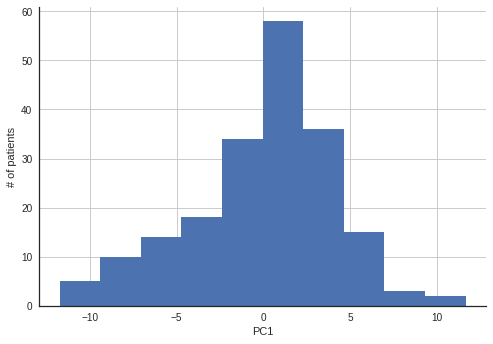

In [32]:
ax=expressionS.hist()
ax.set_xlabel('PC1')
ax.set_ylabel('# of patients')
sns.despine()
ax.figure.savefig(baseDataOutDir+'/BRCA_stage_'+stage+'_PC1.eps')

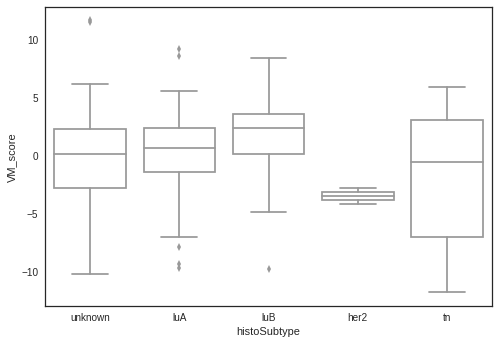

In [33]:
subType_VMScoreDf=subMetaDf[
    #subMetaDf.grade.str.contains(StageRegex2)
    subMetaDf[['VM_score','histoSubtype']].notnull().all(axis=1)
                          ][['VM_score','histoSubtype']].copy()
g=sns.boxplot(data=subType_VMScoreDf,
            x='histoSubtype',y='VM_score',color='White')


In [34]:

m=subType_VMScoreDf.histoSubtype=='tn'
t,p=ttest_ind(subType_VMScoreDf[m].VM_score,subType_VMScoreDf[~m].VM_score)
g.set_title('t:{t} p:{p}'.format(t=t,p=p))

In [35]:
g.figure.savefig(baseDataOutDir+'VM_score_tcga_subtype.pdf')

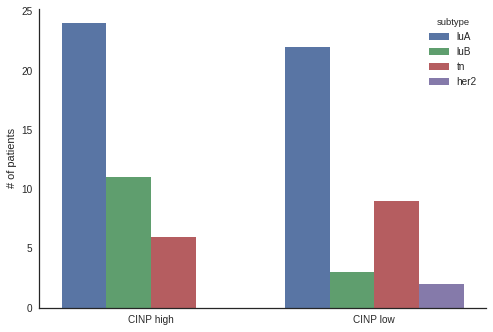

In [36]:
"""
show the distribution of subtype across patient split
"""
tmpDf=subMetaDf[subMetaDf.index.isin(lDf.index)|subMetaDf.index.isin(hDf.index)].copy()
tmpDf.loc[lDf.index,'group']=bottomGroupLabel
tmpDf.loc[hDf.index,'group']=topGroupLabel
assignedDf=tmpDf[~tmpDf.group.isnull()]
plotDf=assignedDf.groupby('group').histoSubtype.value_counts().reset_index(name='count')
plotDf.columns=['group','subtype','count']
ax=sns.barplot(data=plotDf,x='group',hue='subtype',y='count',hue_order=['luA','luB','tn','her2'])
ax.set_ylabel('# of patients')
ax.set_xlabel('')
sns.despine()
ax.figure.savefig(baseDataOutDir+'/BRCA_stage_'+stage+'_subtype.eps')

In [37]:
!echo $PWD/DATA_OUT/

/cellar/users/btsui/Project/STEPHANIE_FINAL/DATA_OUT/


In [38]:
assignedDf.histoSubtype.value_counts()

luA        46
unknown    41
tn         15
luB        14
her2        2
Name: histoSubtype, dtype: int64

### cox regression

In [39]:
subMetaDf.loc[:,'VM_score']=expressionS.loc[:]

In [40]:
subMetaDf.shape,len(expressionS)

((1131, 132), 195)

In [41]:
coxInDf=subMetaDf[subMetaDf.VM_score.notnull()].copy()

In [42]:
stageRawS=coxInDf.grade.str.extract('([IV]+)')

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [43]:
digitToNumeric=pd.Series({'I':1,'II':2,'III':3,'IV':4})

In [44]:
cleanCoxDf=coxInDf[['age','VM_score','E','T']]

In [45]:
cox_VM_score=coxInDf.VM_score.values

In [46]:
cleanCoxDf['stage']=digitToNumeric.loc[stageRawS.fillna('').values].values

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [47]:
multI=pd.MultiIndex.from_arrays([coxInDf.histoSubtype.index,coxInDf.histoSubtype.values])
myCoxTable=pd.Series(index=multI,data=[1]*coxInDf.shape[0]
         ).unstack().fillna(0)


In [48]:
myCoxTable.columns='subType_'+myCoxTable.columns

In [49]:
mergedCoxDf=pd.concat([cleanCoxDf, myCoxTable],axis=1)

In [50]:
validCoxDf=mergedCoxDf.dropna()

In [51]:
from lifelines import CoxPHFitter

cf = CoxPHFitter()

validCoxDf['E']=validCoxDf['E'].astype(np.int64)

tcgacox=coxInDf

validCoxDf['stage'].isnull().any()

subCoxDf=validCoxDf[['VM_score','age','subType_luB',
                   'subType_luA','subType_tn','E','T']]
cf.fit(subCoxDf,'T',event_col='E')

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<lifelines.CoxPHFitter: fitted with 194 observations, 181 censored>

## check grade on PC

In [52]:
luAPatients=subMetaDf.index[subMetaDf.histoSubtype=='luA']

[ 0.28245389  0.10904684  0.07232184]


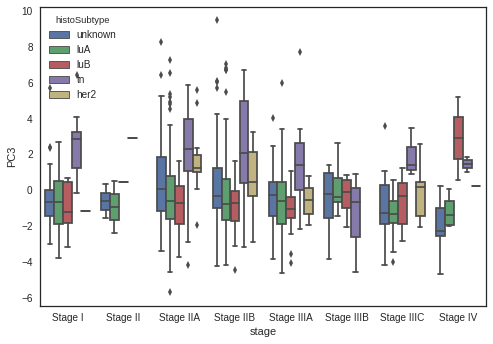

In [53]:
stage='all'
myGrades=['Stage I','Stage II','Stage IIA','Stage IIB','Stage IIIA','Stage IIIB','Stage IIIC','Stage IV']

pca=PCA(n_components=3)

cancerType='BRCA'
myTargetGeneList=hannahGeneList

StageRegex=stageToPatternDict[stage]
#daysThres=365.25*5

mySubMetaDf=metaDf[(metaDf.disease==cancerType)&(metaDf.grade.fillna('').str.contains(StageRegex))&(metaDf.sample_type=='TP')&(~metaDf.filename.str.contains('bam'))]
subTcgaDf=tcgaGeneDf.loc[tcgaGeneDf.index.isin(myTargetGeneList),tcgaGeneDf.columns.isin(mySubMetaDf.index)]
log2SubTcgaDf=np.log2(subTcgaDf+1)
pcaM=pca.fit_transform(log2SubTcgaDf.T)
patientPcaDf=pd.DataFrame(pcaM,index=log2SubTcgaDf.columns,columns=['1','2','3'])
tmpSubMetaDf=subMetaDf.loc[subMetaDf.index.isin(mySubMetaDf.index)].copy()
tmpSubMetaDf['PC3']=patientPcaDf['3']
print pca.explained_variance_ratio_
g=sns.boxplot(data=tmpSubMetaDf[['grade','PC3','histoSubtype']],x='grade',y='PC3',hue='histoSubtype',order=myGrades)

g.set_xlabel('stage')

[ 0.28245389  0.10904684  0.07232184]


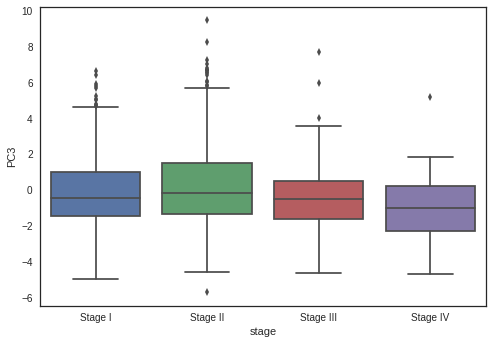

In [54]:
stage='all'
myGrades=['Stage I','Stage II','Stage IIA','Stage IIB','Stage IIIA','Stage IIIB','Stage IIIC','Stage IV']

pca=PCA(n_components=3)

cancerType='BRCA'
myTargetGeneList=hannahGeneList

StageRegex=stageToPatternDict[stage]

mySubMetaDf=metaDf[(metaDf.disease==cancerType)&(metaDf.grade.fillna('').str.contains(StageRegex))&(metaDf.sample_type=='TP')&(~metaDf.filename.str.contains('bam'))]
subTcgaDf=tcgaGeneDf.loc[tcgaGeneDf.index.isin(myTargetGeneList),tcgaGeneDf.columns.isin(mySubMetaDf.index)]
log2SubTcgaDf=np.log2(subTcgaDf+1)
pcaM=pca.fit_transform(log2SubTcgaDf.T)
patientPcaDf=pd.DataFrame(pcaM,index=log2SubTcgaDf.columns,columns=['1','2','3'])
tmpSubMetaDf=subMetaDf.loc[subMetaDf.index.isin(mySubMetaDf.index)].copy()
tmpSubMetaDf['PC3']=patientPcaDf['3']
tmpSubMetaDf['simplifiedGrade']=tmpSubMetaDf.grade.str.replace('[ABC]','')
print pca.explained_variance_ratio_
g=sns.boxplot(data=tmpSubMetaDf[['simplifiedGrade','PC3','histoSubtype']],x='simplifiedGrade',y='PC3',order=['Stage I','Stage II','Stage III','Stage IV'])
#tmpSubMetaDf.histoSubtype.isnull().any()
#tmpSubMetaDf.grade
g.set_xlabel('stage')
g.figure.savefig(baseDataOutDir+'/BRCA_stage_'+stage+'_boxPlot'+'.pdf')

In [55]:
lowGradePatient,highGradePatient=tmpSubMetaDf.PC3[tmpSubMetaDf.grade.str.contains('Stage III|V')],tmpSubMetaDf.PC3[tmpSubMetaDf.grade.str.contains('Stage I{1,2}[ABC]')]
x,y= robjects.FloatVector(lowGradePatient),robjects.FloatVector(highGradePatient)

In [56]:
from scipy.stats import mannwhitneyu
mannwhitneyu(highGradePatient,lowGradePatient)

MannwhitneyuResult(statistic=83735.0, pvalue=9.9881268350709917e-06)

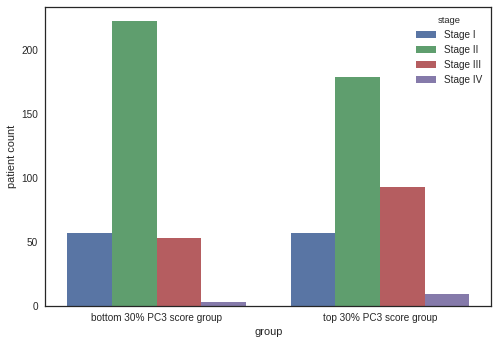

In [57]:
myHueOrder=['Stage I','Stage II','Stage III','Stage IV']
expressionS=patientPcaDf['3']
lExprPatients=expressionS.index[expressionS<=expressionS.quantile(quantile)]
hExprPatients=expressionS.index[expressionS>=expressionS.quantile(1-quantile)]
lDf,hDf=metaDf.loc[metaDf.index.isin(lExprPatients)],metaDf.loc[metaDf.index.isin(hExprPatients)]
tmpDf=subMetaDf[subMetaDf.index.isin(lDf.index)|subMetaDf.index.isin(hDf.index)].copy()
tmpDf.loc[lDf.index,'group']=bottomGroupLabel
tmpDf.loc[hDf.index,'group']=topGroupLabel
assignedDf=tmpDf[~tmpDf.group.isnull()]
assignedDf.loc[:,'stage']=assignedDf.grade.str.replace(r'[ABC]','')
pltDf=assignedDf.groupby('group').stage.value_counts().reset_index(name='count') #hue: stage, x: bottom, top 30, y: count, bar plot
pltDf.columns=['group','stage','count']
g=sns.barplot( data=pltDf,x='group',y='count',hue='stage',hue_order=myHueOrder)
g.set_ylabel('patient count')
g.set_xticklabels(['bottom 30% PC3 score group','top 30% PC3 score group'])
g.figure.savefig(baseDataOutDir+'/allStage_PCA_30%extremeTile.pdf')

In [58]:
from scipy.stats import chisquare
tmpDf=pltDf[pltDf.stage.isin(myHueOrder)]


In [59]:
botDf=tmpDf[tmpDf.group=='bottom 30%'].sort_values('stage')
topDf=tmpDf[tmpDf.group=='top 30%'].sort_values('stage')

In [60]:
chisquare(f_obs=botDf['count'],f_exp=topDf['count'])

Power_divergenceResult(statistic=0.0, pvalue=nan)

## VM Expression heatmap

In [61]:
#get only 2mg and 6mg
condSubsetDf=rawDf.loc[:,rawDf.columns.get_level_values(1).isin({'2-5mg','6mg'})]
stdThreshold=100
geneSubsetDf=condSubsetDf[condSubsetDf.std(axis=1)>stdThreshold]
log2Df=np.log2(geneSubsetDf+1)

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


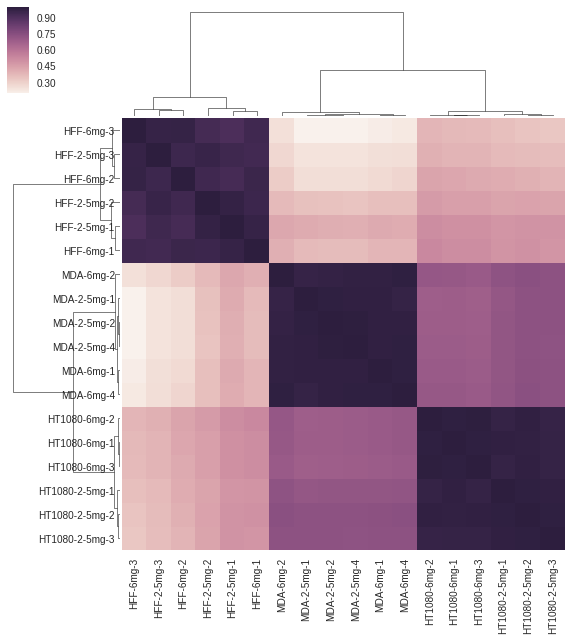

In [62]:
g=sns.clustermap(log2Df.corr())
g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

g.fig.savefig('./DATA_OUT/DATA_raw_corr_heatmap.pdf')

In [63]:
cls=log2Df.columns.get_level_values(0)
meanDf,stdDf= log2Df.mean(axis=1,level=0).loc[:,cls],log2Df.std(axis=1,level=0).loc[:,cls] 
withinZNorm=((log2Df-meanDf.as_matrix())/stdDf.as_matrix()).dropna()
corrDf=withinZNorm.corr()
m=corrDf.index
no2dCorrDf=corrDf.loc[m,m]
condAlgnCorrDf=no2dCorrDf.sort_index(axis=0,level=1).sort_index(axis=1,level=1)


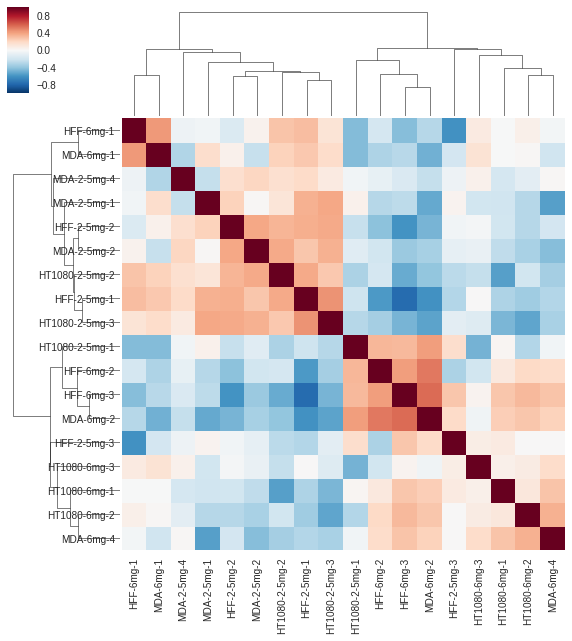

In [64]:
g=sns.clustermap(condAlgnCorrDf)
g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.set_ylabel('')

g.ax_heatmap.set_xlabel('')
g.fig.savefig('./DATA_OUT/DATA_zTranformed_corr_clustermap.pdf')

### VM PCA

[ 0.6639389  0.2882417  0.0151167]


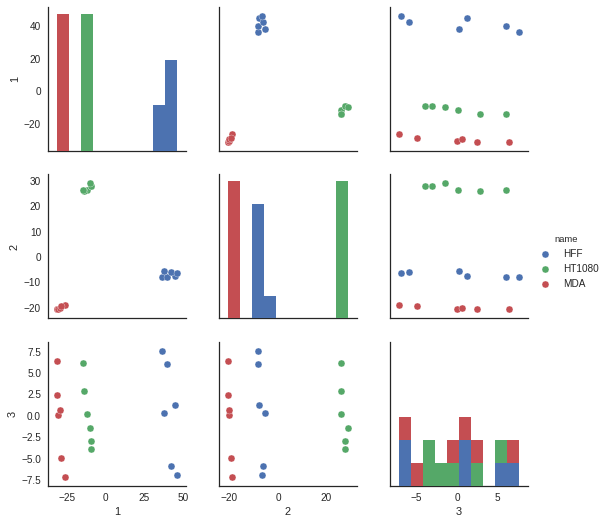

In [65]:
inputDf=log2Df
pcaM=pca.fit_transform(inputDf.T)
pcaDf=pd.DataFrame(pcaM,index=inputDf.columns,columns=['1','2','3'])
print pca.explained_variance_ratio_
#sns.pairplot( pcaDf.reset_index(),hue='level_1')
tmpDf=pcaDf.reset_index()
tmpDf['name']=tmpDf['level_0']
tmpDf2=tmpDf.iloc[:,3:].copy()
g=sns.pairplot(tmpDf2,hue='name')
g.savefig(baseDataOutDir+'/log2_PCA.pdf')

[ 0.33744234  0.14231429  0.08967606]


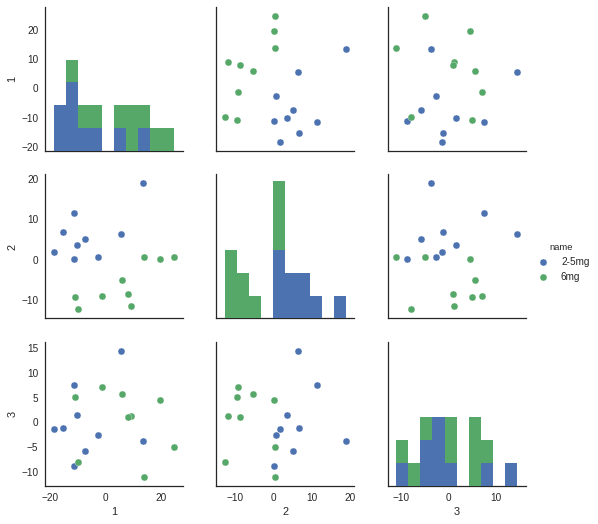

In [66]:
inputDf=withinZNorm
pcaM=pca.fit_transform(inputDf.T)
pcaDf=pd.DataFrame(pcaM,index=inputDf.columns,columns=['1','2','3'])
print pca.explained_variance_ratio_
#sns.pairplot( pcaDf.reset_index(),hue='level_1')
tmpDf=pcaDf.reset_index()
tmpDf['name']=tmpDf['level_1']
tmpDf2=tmpDf.iloc[:,3:].copy()
g=sns.pairplot(tmpDf2,hue='name')
g.savefig(baseDataOutDir+'/z_transformed_PCA.pdf')

## pan cancer

In [67]:
diseaseToPValue={}
#
#stage='II'
#stageMask=metaDf.grade.str.contains('^Stage [I]{1,2}[ABC]?$')==True
#stageRegex=''
#StageRegex=stageToPatternDict[stage]
#gradeMask=(metaDf.grade.fillna('').str.contains(StageRegex))
stageMetaDf=metaDf[(metaDf.sample_type=='TP')&(~metaDf.filename.str.contains('bam'))]
diseasePatientCount=stageMetaDf.disease.value_counts()
validDiseases=diseasePatientCount.index[diseasePatientCount>4]
diseaseToN_PerGroup={}
diseaseToN={}
for cancerType in validDiseases:
    mySubMetaDf=stageMetaDf[stageMetaDf.disease==cancerType]
    subTcgaDf=tcgaGeneDf.loc[tcgaGeneDf.index.isin(myTargetGeneList),tcgaGeneDf.columns.isin(mySubMetaDf.index)]
    log2SubTcgaDf=np.log2(subTcgaDf+1)
    pcaM=pca.fit_transform(log2SubTcgaDf.T)
    patientPcaDf=pd.DataFrame(pcaM,index=log2SubTcgaDf.columns,columns=['1','2','3'])
    meanA=log2SubTcgaDf.loc[:,patientPcaDf['1']<=patientPcaDf['1'].quantile(quantile)].mean().mean()
    meanB=log2SubTcgaDf.loc[:,patientPcaDf['1']>=patientPcaDf['1'].quantile(1-quantile)].mean().mean()
    expressionS=(-patientPcaDf['1']) if meanB<meanA else patientPcaDf['1']
    
    lExprPatients=expressionS.index[expressionS<=expressionS.quantile(quantile)]
    hExprPatients=expressionS.index[expressionS>=expressionS.quantile(1-quantile)]
    lDf,hDf=metaDf.loc[metaDf.index.isin(lExprPatients)],metaDf.loc[metaDf.index.isin(hExprPatients)]
    result=logrank_test(hDf['T'],lDf['T'],hDf['E'],lDf['E'])
    diseaseToPValue[cancerType]=result.p_value
    diseaseToN_PerGroup[cancerType]=len(lExprPatients)
    diseaseToN[cancerType]=len(expressionS)

In [68]:
###check the PC1 expression cohort 
overA=log2SubTcgaDf.loc[:,patientPcaDf['1']<=patientPcaDf['1'].quantile(quantile)].mean().mean()
overB=log2SubTcgaDf.loc[:,patientPcaDf['1']>=patientPcaDf['1'].quantile(1-quantile)].mean().mean()
overA

4.573019027709961

In [69]:
sampleSizeDf=pd.DataFrame({'log_rank_p':pd.Series(diseaseToPValue).sort_values(),
                           'n_per_group':pd.Series(diseaseToN_PerGroup),
            'n':pd.Series(diseaseToN)}).sort_values('log_rank_p')
tcga_log_rankDf=sampleSizeDf

In [70]:
diseaseToPValue={}
stageMetaDf=metaDf[(metaDf.sample_type=='TP')&(~metaDf.filename.str.contains('bam'))]
diseasePatientCount=stageMetaDf.disease.value_counts()
validDiseases=diseasePatientCount.index[diseasePatientCount>4]
diseaseToN={}
myCoxDfList=[]
for cancerType in validDiseases:
    mySubMetaDf=stageMetaDf[stageMetaDf.disease==cancerType]
    subTcgaDf=tcgaGeneDf.loc[tcgaGeneDf.index.isin(myTargetGeneList),tcgaGeneDf.columns.isin(mySubMetaDf.index)]
    log2SubTcgaDf=np.log2(subTcgaDf+1)
    pcaM=pca.fit_transform(log2SubTcgaDf.T)
    patientPcaDf=pd.DataFrame(pcaM,index=log2SubTcgaDf.columns,columns=['1','2','3'])
    meanA=log2SubTcgaDf.loc[:,patientPcaDf['1']<=patientPcaDf['1'].quantile(quantile)].mean().mean()
    meanB=log2SubTcgaDf.loc[:,patientPcaDf['1']>=patientPcaDf['1'].quantile(1-quantile)].mean().mean()
    expressionS=(-patientPcaDf['1']) if meanB<meanA else patientPcaDf['1']

    mySubMetaDf.loc[:,'VM_score']=expressionS
    cf.fit(mySubMetaDf[['age','VM_score','E','T']].dropna(),'T',event_col='E')
    tmpDf=cf.summary.copy()
    tmpDf['cancer_type']=cancerType
    myCoxDfList.append(tmpDf)

In [72]:
mergedCoxDf=pd.concat(myCoxDfList,axis=0)

In [73]:
mergedCoxDf['covar']=mergedCoxDf.index

In [75]:
all_coxDf=mergedCoxDf.set_index(['cancer_type','covar'])

In [76]:
excel=pd.ExcelWriter(baseDataOutDir+'all_cox.xlsx')
all_coxDf.to_excel(excel)
excel.close()

### generate venn digram

In [80]:

cellLineToGeneList={cellLine:set(imputedMeanFoldChangeDf.index[imputedMeanFoldChangeDf[cellLine]>1.5].tolist()) for cellLine in imputedMeanFoldChangeDf.columns}

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/matplotlib/artist.py:233: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


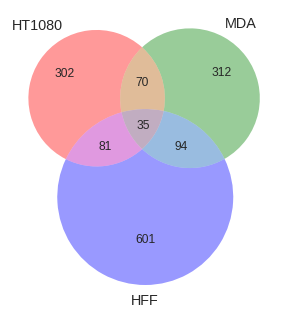

In [81]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
myPlot=plt.subplot()
ax=myPlot.get_axes()
venn3(subsets=cellLineToGeneList.values(),set_labels=cellLineToGeneList.keys(),ax=ax)
ax.figure.savefig(baseDataOutDir+'/venn.pdf')

# load metabric data

In [83]:
bric_exprDir='./metabric/brca_metabric/data_expression.txt'

In [84]:
bric_clinDir='./metabric/brca_metabric/brca_metabric_clinical_data.tsv'

In [85]:
bric_exprDf=pd.read_csv(bric_exprDir,sep='\t')

In [86]:
bric_clinDf=pd.read_csv(bric_clinDir,sep='\t')

In [87]:
myTargetS=pd.Series(myTargetGeneList).str.replace('NREP','C5orf13')

In [88]:
metaBricSubDf=bric_exprDf[
    bric_exprDf['Hugo_Symbol'].isin(myTargetS)].set_index('Hugo_Symbol').iloc[:,1:]

In [89]:
genelist_metaBricDf=metaBricSubDf.loc[myTargetS].fillna(0)

In [90]:
pcaM=pca_low_grade_brca.transform(genelist_metaBricDf.T)
genelist_metaBricDf
inPcaDf=genelist_metaBricDf
pcaM=pca_low_grade_brca.fit_transform(inPcaDf.T)
pc=0
patientPcaDf=pd.DataFrame(pcaM,index=inPcaDf.columns,)
meanA=inPcaDf.loc[:,patientPcaDf[pc]<=patientPcaDf[pc].quantile(quantile)].mean().mean()
meanB=inPcaDf.loc[:,patientPcaDf[pc]>=patientPcaDf[pc].quantile(1-quantile)].mean().mean()
bric_expressionS=(-patientPcaDf[pc]) if meanB<meanA else patientPcaDf[pc]


In [91]:
timeLabel='Overall Survival (Months)'
eventLabel="Patient's Vital Status"
subtypeLabel='3-Gene classifier subtype'
indexLabel='Patient ID'
ageLabel='Age at Diagnosis'
stageLabel='Tumor Stage'

In [92]:
bric_E=bric_clinDf[eventLabel].fillna('').str.contains('Died of Disease')

In [93]:
coxDf=bric_clinDf.set_index(indexLabel)[
    [timeLabel,'Age at Diagnosis',subtypeLabel,stageLabel]]

In [94]:
coxDf['EVENT']=bric_E.astype(np.int).values

In [95]:
bric_clinDf['1']=1

In [96]:
brci_subtypeDf=bric_clinDf.set_index([subtypeLabel,indexLabel]
                     )['1'].unstack().fillna(0).T

In [97]:
bric_subtypes=brci_subtypeDf.columns

In [98]:
brci_subtypeDf.columns=bric_subtypes

In [99]:
merged_subtypeDf=pd.concat([coxDf,brci_subtypeDf],axis=1)

In [100]:
merged_subtypeDf.loc[:,'VM_score']=bric_expressionS#(-bric_expressionS.loc[:] if flip else bric_expressionS.loc[:])

In [101]:
bric_validDf=merged_subtypeDf.dropna()

In [102]:
myStage=2
stage_m=bric_validDf[stageLabel]==myStage
mySubTypes=['ER+/HER2- High Prolif', 'ER+/HER2- Low Prolif', 'ER-/HER2-', 'HER2+']
inCoxDf=bric_validDf[stage_m][['VM_score',ageLabel,\
                      'EVENT',timeLabel]+
                     ['ER+/HER2- High Prolif', 'ER+/HER2- Low Prolif', 'ER-/HER2-']].copy()

In [103]:
"""
figure how the high VM with the low VM 
"""

'\nfigure how the high VM with the low VM \n'

In [104]:
excel=pd.ExcelWriter(baseDataOutDir+'metabric_cox.xlsx')
cf.fit(inCoxDf,timeLabel,event_col='EVENT')
erly_df=cf.summary
erly_df.to_excel(excel,sheet_name="stage "+str(myStage))
excel.close()

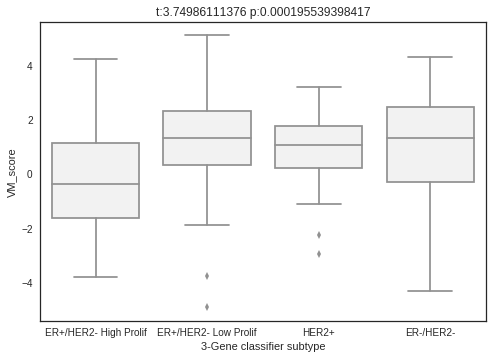

In [106]:
selectedSubtypes=bric_clinDf[subtypeLabel].value_counts().index#[:3]
downSampledBricDf=bric_validDf[bric_validDf[subtypeLabel].isin(selectedSubtypes)
                               
                              ].groupby(subtypeLabel).head(bric_validDf[subtypeLabel].value_counts().min())

g=sns.boxplot(data=downSampledBricDf[downSampledBricDf[stageLabel]==1],y='VM_score',x=subtypeLabel,color='White')
g.legend([])

A=downSampledBricDf[downSampledBricDf[subtypeLabel]=='ER-/HER2-']['VM_score']
B=downSampledBricDf[~(downSampledBricDf[subtypeLabel]=='ER-/HER2-')]['VM_score']
t,p=ttest_ind(A,B)
g.set_title('t:{t} p:{p}'.format(t=t,p=p))

In [107]:
g.figure.savefig(baseDataOutDir+'VM_score_metabric_subtype.pdf')

In [108]:
fondSize=20
params = {'legend.fontsize': fondSize,
          'figure.figsize': (10, 5),
         'axes.labelsize': fondSize,
         'axes.titlesize':fondSize,
         'xtick.labelsize':fondSize,
         'ytick.labelsize':fondSize}
mpl.rcParams.update(params)

### metabric stage I

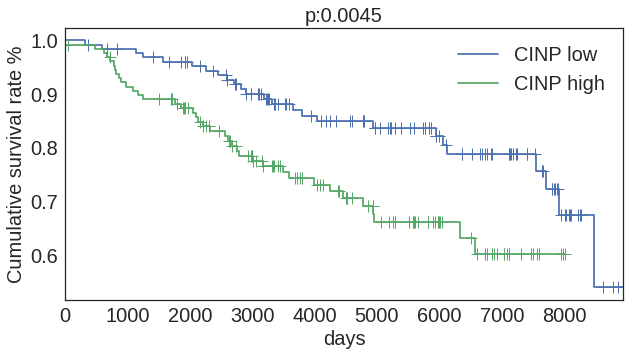

In [110]:

my_meta_bric=1
tripNegDf=bric_validDf[(bric_validDf['Tumor Stage']==my_meta_bric)]#[(bric_validDf[subtypeLabel]=='ER-/HER2-')&(bric_validDf['EVENT'])&(bric_validDf['Tumor Stage']==1)]

tripNegCoxDf=tripNegDf[[timeLabel,ageLabel,'EVENT','VM_score']]
cf.fit(tripNegCoxDf,timeLabel,event_col='EVENT')
cf.summary

bric_validDf['Tumor Stage'].value_counts()

"""
check results with Chisquare 
"""
topQ=0.3
hdf=tripNegCoxDf[tripNegCoxDf.VM_score>=tripNegCoxDf.VM_score.quantile(1-topQ)]
ldf=tripNegCoxDf[tripNegCoxDf.VM_score<=tripNegCoxDf.VM_score.quantile(topQ)]

log_rank_p=logrank_test(hdf[timeLabel],ldf[timeLabel],hdf['EVENT'],ldf['EVENT'])
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
kmf.fit(ldf[timeLabel]*30, event_observed=ldf['EVENT'], label=bottomGroupLabel)
kmf.plot(ax=ax,show_censors=True,ci_show=False)
kmf.fit(hdf[timeLabel]*30, event_observed=hdf['EVENT'], label=topGroupLabel)
kmf.plot(ax=ax,show_censors=True,ci_show=False)
ax.set_title('p:{p}'.format(p="%.4f"%(log_rank_p.p_value)))
ax.set_xlabel('days')
ax.set_ylabel('Cumulative survival rate %')
ax.figure.savefig(baseDataOutDir+'metabric_stage_km_{stage}.eps'.format(stage=my_meta_bric),bbox_inches='tight')